1. Process data into pickles with skip 40
2. Load this in to df dataloader
3. Train simple MLP map o -> a, observe it being okay
4. Get play subsequences, do goal conditioned BC, not just BC
5. LFP planner/encoder
6. Label a couple subsequences w/ language, and map that to the z space!

# Data Creation

In [1]:
# # # Clean old data
# import glob
# import os
# demo_dir = os.getcwd() + '/' + "kitchen_demos_multitask/"
# old = glob.glob(demo_dir + "/**/*.pkl", recursive=True)
# movies = glob.glob(demo_dir + "/**/*.mp4", recursive=True)
# for i in old + movies:
#     print(i)
#     os.remove(i)

/home/sholto/Desktop/AI/learning_from_play/kitchen_demos_multitask/postcorl_kettle_topknob_bottomknob_hinge/kitchen_playdata_2019_07_11_18_06_46_playback.mp4
/home/sholto/Desktop/AI/learning_from_play/kitchen_demos_multitask/friday_microwave_bottomknob_switch_slide/kitchen_playdata_2019_06_28_12_39_06_playback.mp4
/home/sholto/Desktop/AI/learning_from_play/kitchen_demos_multitask/friday_microwave_kettle_bottomknob_slide/kitchen_playdata_2019_06_28_12_02_31_playback.mp4


UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [1]:

#ata.build_dataset_from_mjl('', num_cpus=2)

# Dataset

In [1]:
import glob
import data
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
dataset_path  = '' # '../relay-policy-learning'

In [2]:
observations, actions, cnt, init_poses, init_vels = data.create_single_dataset(dataset_path)
# cnt is for the histogram

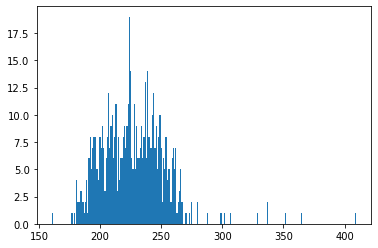

In [3]:
# Histogram of sequence lengths
plt.bar(cnt.keys(), cnt.values(), width=1)
plt.show()

In [114]:

dataset = {'obs':observations, 'acts': actions, 'init_poses': init_poses, 'init_vels': init_vels}
train_partition = 0.8
N_TRAJS = len(dataset['obs'])
train_data = {key:value[:int(N_TRAJS*train_partition)] for key, value in dataset.items()}
valid_data = {key:value[int(N_TRAJS*train_partition):] for key, value in dataset.items()}

START_OBS, END_OBS = 0,30
START_GOAL, END_GOAL = 9,30

In [115]:

def sample_MLP_GCBC_batch(data, batch_size = 64):
    obs, acts = data['obs'], data['acts']
    traj_idxs = np.random.choice(len(obs), batch_size)
    batch_obs = []
    batch_acts = [] 
    batch_goals = [] 
    for idx in traj_idxs:
        traj = obs[idx]
        tstep = np.random.choice(len(traj))
        batch_obs.append(obs[idx][tstep][START_OBS:END_OBS]), batch_acts.append(acts[idx][tstep])
        batch_goals.append(obs[idx][-1][START_GOAL:END_GOAL])
        
    batch_obs = np.concatenate([batch_obs, batch_goals], -1)
    return tf.convert_to_tensor(batch_obs, tf.float32), tf.convert_to_tensor(batch_acts, tf.float32)


In [116]:
%%time
obs, acts = sample_MLP_GCBC_batch(train_data)

CPU times: user 2.21 ms, sys: 86 µs, total: 2.29 ms
Wall time: 1.64 ms


# Model

In [117]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input

## Simple MLP Baseline
Use this to map obs -> act

In [118]:
class deterministic_MLP(tf.keras.Model):

    def __init__(self, act_dim, layer_size = 256):
        super(deterministic_MLP, self).__init__()
        self.dense1 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(act_dim, activation=None)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)
    
    def act(self, inputs):
        return self.call(inputs)
    
    
class stochastic_MLP(tf.keras.Model):

    def __init__(self, act_dim, num_distribs = 3, layer_size = 256):
        super(stochastic_MLP, self).__init__()
        self.num_distribs = num_distribs
        self.act_dim = act_dim
        self.dense1 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(layer_size, activation=tf.nn.relu)
        self.mu = tf.keras.layers.Dense(act_dim*num_distribs, activation=None)
        self.scale = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")
        self.weightings = tf.keras.layers.Dense(act_dim*num_distribs, activation="softplus")

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        mu, scale, weightings = self.mu(x), self.scale(x), self.weightings(x)
        mu, scale, weightings = tf.reshape(mu, (-1, self.act_dim, self.num_distribs)), tf.reshape(scale, (-1, self.act_dim, self.num_distribs)), tf.reshape(weightings, (-1, self.act_dim, self.num_distribs))
        dist = tfd.Logistic(loc=mu, scale=scale)
        
        mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
                          probs=weightings),components_distribution=dist)
        
        return mixture
    
    def act(self, inputs):
        return self.call(inputs).sample()

# Training Loop

In [208]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


import time
PROBS = True
SEQ = False
act_dim =  9

In [229]:

@tf.function
def step(obs,acts, model):
    mu = model(obs)
    loss = tf.reduce_mean(tf.losses.MSE(mu, acts))
    return loss

@tf.function
def probabilistic_step(obs,acts, model):
    
    mixture = model(obs)
    
    loss = -tf.reduce_mean(mixture.log_prob(acts))
    return loss

@tf.function    
def train_step(obs,acts, model, optimizer):
    with tf.GradientTape() as tape:
        loss = step(obs,acts, model)
        
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss
        

In [230]:
# Instantiate an optimizer to train the model.
optimizer = Adam(learning_rate=2e-4)
# Instantiate a loss function.

if PROBS:
    step = probabilistic_step
    if SEQ:
        model = LSTM(act_dim = act_dim)
    else:
        model = stochastic_MLP(act_dim = act_dim)
else:
    model = deterministic_MLP(act_dim=act_dim)
    get_batch = sample_MLP_GCBC_batch

# Prepare the metrics.
# train_acc_metric = Accuracy()

30000/30000 [==============================] - 102s 3ms/step - Loss: -0.8652


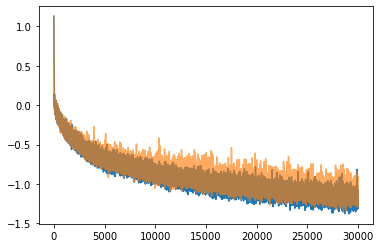

In [231]:
n_steps = 30000
t = 0
steps = []
losses = []
valid_losses = []


progbar = Progbar(n_steps, verbose=1, interval=0.5)
data_time = []
train_time = []
# TODO RAY async trajectories in background
for t in range(0, n_steps):
    t1 = time.time()
    train_obs, train_acts = get_batch(train_data)
    t2 = time.time()
    data_time.append(t2-t1)
    loss = train_step(train_obs,train_acts, model, optimizer)
    t3 = time.time()
    train_time.append(t3-t2)
    steps.append(t)
    losses.append(loss)
    valid_obs, valid_acts = get_batch(valid_data)
    valid_loss = step(valid_obs, valid_acts, model)
    valid_losses.append(valid_loss)
    progbar.add(1, [('Loss', valid_loss)])
    
    
plt.plot(steps, losses)
plt.plot(steps, valid_losses, alpha = 0.65)

In [232]:
print(sum(data_time), sum(train_time)) #Tristan pls fix my retarded data input pipieline

26.4440758228302 25.710469245910645


In [143]:
model.summary()

Model: "stochastic_mlp_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             multiple                  13312     
_________________________________________________________________
dense_31 (Dense)             multiple                  65792     
_________________________________________________________________
dense_32 (Dense)             multiple                  65792     
_________________________________________________________________
dense_33 (Dense)             multiple                  6939      
_________________________________________________________________
dense_34 (Dense)             multiple                  6939      
_________________________________________________________________
dense_35 (Dense)             multiple                  6939      
Total params: 165,713
Trainable params: 165,713
Non-trainable params: 0
____________________________________________

In [147]:
model(tf.random.normal((1,200,51))).sample()

<tf.Tensor: shape=(200, 9), dtype=float32, numpy=
array([[ 0.7406805 , -0.26324248,  0.2625637 , ..., -0.43781585,
        -1.2049782 ,  0.79867715],
       [ 1.734206  ,  0.789835  ,  0.01171464, ..., -0.7460112 ,
        -1.018531  ,  1.8334589 ],
       [ 0.51335365,  0.35345563, -0.13754956, ...,  0.2514869 ,
        -0.8373769 ,  1.8751845 ],
       ...,
       [-0.1738874 ,  0.3033693 ,  0.6624936 , ...,  0.38299224,
         1.6595734 , -1.3870286 ],
       [ 0.7093509 ,  0.65628535,  0.14237264, ...,  0.84538925,
        -0.9332779 ,  1.3460374 ],
       [-0.80793804,  0.3353363 ,  0.28218392, ...,  0.5938243 ,
         1.0928881 , -1.3894249 ]], dtype=float32)>

# Evaluation

In [12]:
import gym
import adept_envs

env = gym.make("kitchen_relax-v1")

Reading configurations for Franka
Initializing Franka sim
registering the liscence


/home/sholto/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [271]:
n_valid_trajectories = len(valid_data['obs'])
idx = np.random.choice(n_valid_trajectories)
traj_obs, traj_acts, traj_init_o, traj_init_v = [valid_data[key][idx] for key in valid_data.keys()]

In [272]:

o = env.reset()
ZERO, QUARTER, HALF, THREEQ = 0, len(traj_obs)//4, len(traj_obs)//2, len(traj_obs)*3//4
init_o = traj_obs[THREEQ][START_OBS:END_OBS]# traj_init_o
env.robot.reset(env, init_o, traj_init_v)
goal = traj_obs[-1][START_GOAL:END_GOAL]
for i in range(len(traj_acts)):
    o = tf.expand_dims(np.concatenate([o[START_OBS:END_OBS], goal], -1),0)
    if PROBS:
        a = model(o).sample()[0]
    else:
        a = model.predict(o)[0]
    #a = traj_acts[i]
    o, r, d, _ = env.step(a) # the key change
    
    env.render()

In [131]:
goal

array([-4.37199715e-04, -1.31206806e-04, -8.61072036e-01, -4.95768697e-03,
       -2.08822888e-05, -5.95385239e-06,  5.34107801e-05, -2.23215419e-05,
        2.14249859e-05,  3.61204103e-04,  3.18400169e-01,  8.23402408e-03,
        1.45513412e+00, -6.74479740e-01, -2.69193908e-01,  3.49609265e-01,
        1.61891507e+00,  1.00742005e+00,  2.57400471e-03,  6.43422086e-03,
       -3.33867545e-04])

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
#     val_acc_metric.update_state(y, val_logits)

In [74]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    start_time = time.time()
    progbar = Progbar(len(observations), verbose=1, interval=0.5)

    # Iterate over the batches of the dataset.
    for step, (obs,acts) in enumerate(zip(observations, actions)):
#         obs = traj_batch['observations']
#         acts = traj_batch['actions']
    
        loss_value = train_step(obs, acts)
        progbar.add(1, [('Loss', loss_value)])
#     print()
        
    # Display metrics at the end of each epoch.
#     train_acc = train_acc_metric.result()
#     print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
#     train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
#     for x_batch_val, y_batch_val in val_dataset:
#         test_step(x_batch_val, y_batch_val)

#     val_acc = val_acc_metric.result()
#     val_acc_metric.reset_states()
#     print("Validation acc: %.4f" % (float(val_acc),))    


Epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  1/565 [..............................] - ETA: 2:46 - Loss: 0.2236WARNING:tensorflow:5 out of the last 5 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


  7/565 [..............................] - ETA: 1:06 - Loss: 0.2273WARNING:tensorflow:8 out of the last 8 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 12/565 [..............................] - ETA: 1:01 - Loss: 0.2245WARNING:tensorflow:11 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 19/565 [>.............................] - ETA: 55s - Loss: 0.2090 WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 28/565 [>.............................] - ETA: 48s - Loss: 0.1998WARNING:tensorflow:8 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 34/565 [>.............................] - ETA: 47s - Loss: 0.1960WARNING:tensorflow:9 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 41/565 [=>............................] - ETA: 45s - Loss: 0.1879WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 50/565 [=>............................] - ETA: 42s - Loss: 0.1790WARNING:tensorflow:7 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 58/565 [==>...........................] - ETA: 40s - Loss: 0.1715WARNING:tensorflow:9 out of the last 14 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 66/565 [==>...........................] - ETA: 39s - Loss: 0.1668WARNING:tensorflow:9 out of the last 13 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 77/565 [===>..........................] - ETA: 36s - Loss: 0.1622WARNING:tensorflow:6 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 87/565 [===>..........................] - ETA: 34s - Loss: 0.1583WARNING:tensorflow:7 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


 94/565 [===>..........................] - ETA: 34s - Loss: 0.1555WARNING:tensorflow:9 out of the last 11 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


131/565 [=====>........................] - ETA: 24s - Loss: 0.1471WARNING:tensorflow:5 out of the last 16 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


161/565 [=======>......................] - ETA: 20s - Loss: 0.1430WARNING:tensorflow:5 out of the last 16 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


183/565 [========>.....................] - ETA: 17s - Loss: 0.1403WARNING:tensorflow:5 out of the last 12 calls to <function train_step at 0x7f9e0c699050> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


565/565 [==============================] - 10s 19ms/step - Loss: 0.1199

Epoch 1
565/565 [==============================] - 0s 615us/step - Loss: 0.0969

Epoch 2
565/565 [==============================] - 0s 635us/step - Loss: 0.0876

Epoch 3
565/565 [==============================] - 0s 604us/step - Loss: 0.0812

Epoch 4
565/565 [==============================] - 0s 616us/step - Loss: 0.0763

Epoch 5
565/565 [==============================] - 0s 634us/step - Loss: 0.0722

Epoch 6
565/565 [==============================] - 0s 620us/step - Loss: 0.0688

Epoch 7
565/565 [==============================] - 0s 615us/step - Loss: 0.0659

Epoch 8
565/565 [==============================] - 0s 646us/step - Loss: 0.0631

Epoch 9
565/565 [==============================] - 0s 676us/step - Loss: 0.0607

Epoch 10
565/565 [==============================] - 0s 641us/step - Loss: 0.0586

Epoch 11
565/565 [==============================] - 0s 603us/step - Loss: 0.0568

Epoch 12
565/565 [================